# Installation & Setup

In [1]:
#this cell only needs to be run once for every new run time
!pip install -U tensorflow-text --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 43.5 MB/s eta 0:00:00


In [2]:
#this cell only needs to be run once for every new run time
!pip install torch --quiet
!pip install datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 8.9 MB/s eta 0:00:00


In [3]:
#this cell only needs to be run once for every new run time
!pip install transformers[torch] accelerate -U --quiet #torch needed for pytorch. Based on error, needed this so that Trainer object will work

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.8 MB/s eta 0:00:00


In [4]:
# Code copied from Jennifer
! pip install transformers datasets --quiet

In [5]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter0/1?fw=pt.
# Development version of transformers
!pip install transformers[sentencepiece] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import os
import re

import torch

# Code copied from https://huggingface.co/learn/nlp-course/chapter0/1?fw=pt.
import transformers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

from datasets import Dataset
# Code copied from Jennifer and https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
from datasets import load_dataset

from transformers import AutoModel, AutoTokenizer, AddedToken
# Code copied from: https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt and https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import HuggingFace Models

In [8]:
#CharBERT model
charbert_name = "imvladikon/charbert-bert-wiki"
charbert_model = AutoModel.from_pretrained(charbert_name)
charbert_tokenizer = AutoTokenizer.from_pretrained(charbert_name)

In [9]:
#RoBERTa model
# roberta_name = "imvladikon/charbert-roberta-wiki"
# roberta_model = AutoModel.from_pretrained(roberta_name)
# roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)

# Import Data & Processing
Change the data_path to your directory as needed

1.   key: the key pressed
2.   response_id: unique identifying code for this participant typing this
target sentence
3. response_content: response for this sentence as typed in full
4. participant_id: unique ID for participant
5. sentence_id: identifier for target sentence
6. sentence_content: target sentence as displayed to the participant
7. diagnosis:
> *   1=Typist has had a diagnosis of Parkinson's disease;
> * 0=Typist has not had a diagnosis of Parkinson's disease
8. keydown: Timestamp for press of key in milliseconds
9. keyup: Timestamp for release of key in milliseconds


In [10]:
#add path to data
data_path = '/content/drive/My Drive/266 Assignments/266 Final Project'

files = os.listdir(data_path)
files = [x for x in files if '.csv' in x]
files

['online_english_fold_all.csv',
 'MedicationInfo.csv',
 'CoNLL_2020_Online_English.csv']

## Data processing
*   Create key_duration_ms column, which is keyup - keydown
*   Replace non-character keys (e.g. shift, enter, space, backspace, control) with special tokens




In [11]:
df = pd.read_csv(os.path.join(data_path, files[files.index('CoNLL_2020_Online_English.csv')]))
df

,key,response_id,response_content,participant_id,sentence_id,sentence_content,diagnosis,keydown,keyup
0,shift,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80077.6719,80672.2719
1,b,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80511.5719,80615.2719
2,o,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80800.2719,80861.4719
3,o,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80949.9719,81076.3719
4,s,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,81305.5719,81480.7719
...,...,...,...,...,...,...,...,...,...
437910,r,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,709861.2300,709965.3350
437911,k,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,709997.2450,710077.2900
437912,e,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,710165.2550,710309.3200
437913,t,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,710413.2600,710509.4550


In [12]:
df['key_duration_ms'] = df['keyup'] - df['keydown']
df

,key,response_id,response_content,participant_id,sentence_id,sentence_content,diagnosis,keydown,keyup,key_duration_ms
0,shift,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80077.6719,80672.2719,594.600
1,b,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80511.5719,80615.2719,103.700
2,o,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80800.2719,80861.4719,61.200
3,o,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80949.9719,81076.3719,126.400
4,s,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,81305.5719,81480.7719,175.200
...,...,...,...,...,...,...,...,...,...,...
437910,r,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,709861.2300,709965.3350,104.105
437911,k,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,709997.2450,710077.2900,80.045
437912,e,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,710165.2550,710309.3200,144.065
437913,t,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,710413.2600,710509.4550,96.195


In [13]:
# #check distribution of key times per one response
# df.loc[df['response_id']==53, 'key_duration_ms'].plot.hist()

In [14]:
key_vocab = df['key'].unique()

#regex pattern
# pattern = r"^[\w,!.@#$%^}\&_{='/:);(|[\]]$"
pattern = r"^[\w,!.@#$%^}\&_{='/:);(|[\]\"'\\\\-]$"

#include only alphanumeric characters and special characters
vocab_subset = []

for i in key_vocab:
  matches = re.findall(pattern, i)
  vocab_subset.extend(matches)

vocab_subset.sort()
# vocab_subset

In [15]:
remaining_vocab = list(set(key_vocab) - set(vocab_subset))
remaining_vocab

['enter',
 'delete',
 'contextmenu',
 'unidentified',
 'arrowleft',
 'f11',
 'alt',
 'tab',
 'home',
 ' ',
 'arrowup',
 'end',
 'insert',
 'shift',
 'f16',
 'arrowdown',
 'mediaprevioustrack',
 'capslock',
 'backspace',
 'spacebar',
 '\n',
 'numlock',
 'process',
 'meta',
 'control',
 'pagedown',
 'arrowright']

In [16]:
#both ' ' and 'spacebar' are classed as '[SPCE]'
df.loc[df['key'] == ' ', 'key'] = 'spacebar'

#get all punctuation and alphanumeric characters
def clean_key(key):
    if key in vocab_subset:
        return key
    elif key in remaining_vocab:
        return '[' + key +']'
    else:
        return None
df['key_clean'] = df['key'].apply(clean_key)


df

,key,response_id,response_content,participant_id,sentence_id,sentence_content,diagnosis,keydown,keyup,key_duration_ms,key_clean
0,shift,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80077.6719,80672.2719,594.600,[shift]
1,b,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80511.5719,80615.2719,103.700,b
2,o,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80800.2719,80861.4719,61.200,o
3,o,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80949.9719,81076.3719,126.400,o
4,s,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,81305.5719,81480.7719,175.200,s
...,...,...,...,...,...,...,...,...,...,...,...
437910,r,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,709861.2300,709965.3350,104.105,r
437911,k,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,709997.2450,710077.2900,80.045,k
437912,e,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,710165.2550,710309.3200,144.065,e
437913,t,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,710413.2600,710509.4550,96.195,t


In [17]:
clean_vocab = list(df['key_clean'].unique())
#get a list of the special keys
special_tokens = []
for i in clean_vocab:
  if '[' in i and ']' in i:
    special_tokens.append(i)

special_tokens

['[shift]',
 '[backspace]',
 '[spacebar]',
 '[enter]',
 '[\n]',
 '[unidentified]',
 '[arrowleft]',
 '[arrowright]',
 '[arrowdown]',
 '[capslock]',
 '[delete]',
 '[numlock]',
 '[insert]',
 '[f11]',
 '[meta]',
 '[control]',
 '[arrowup]',
 '[mediaprevioustrack]',
 '[alt]',
 '[end]',
 '[pagedown]',
 '[tab]',
 '[f16]',
 '[process]',
 '[home]',
 '[contextmenu]']

In [18]:
#add special tokens to CharBERT vocab
unused_token_slots = [f"[unused{i}]" for i in range(1, len(special_tokens) + 1)]

charbert_token_map = dict(zip(special_tokens, unused_token_slots))
charbert_token_map

{'[shift]': '[unused1]',
 '[backspace]': '[unused2]',
 '[spacebar]': '[unused3]',
 '[enter]': '[unused4]',
 '[\n]': '[unused5]',
 '[unidentified]': '[unused6]',
 '[arrowleft]': '[unused7]',
 '[arrowright]': '[unused8]',
 '[arrowdown]': '[unused9]',
 '[capslock]': '[unused10]',
 '[delete]': '[unused11]',
 '[numlock]': '[unused12]',
 '[insert]': '[unused13]',
 '[f11]': '[unused14]',
 '[meta]': '[unused15]',
 '[control]': '[unused16]',
 '[arrowup]': '[unused17]',
 '[mediaprevioustrack]': '[unused18]',
 '[alt]': '[unused19]',
 '[end]': '[unused20]',
 '[pagedown]': '[unused21]',
 '[tab]': '[unused22]',
 '[f16]': '[unused23]',
 '[process]': '[unused24]',
 '[home]': '[unused25]',
 '[contextmenu]': '[unused26]'}

In [19]:
added_tokens = [AddedToken(token) for token in charbert_token_map.values()]

# Add the special tokens from charbert_token_map to the tokenizer's vocabulary
charbert_tokenizer.add_tokens(added_tokens)

26

In [20]:
df['charbert_key'] = df['key_clean'].map(charbert_token_map)
df['charbert_key'] = df['charbert_key'].fillna(df['key_clean'])
df

,key,response_id,response_content,participant_id,sentence_id,sentence_content,diagnosis,keydown,keyup,key_duration_ms,key_clean,charbert_key
0,shift,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80077.6719,80672.2719,594.600,[shift],[unused1]
1,b,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80511.5719,80615.2719,103.700,b,b
2,o,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80800.2719,80861.4719,61.200,o,o
3,o,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,80949.9719,81076.3719,126.400,o,o
4,s,39,"Books include Penguin Island, a satire on the ...",11,1,"Books include Penguin Island, a satire on the ...",1,81305.5719,81480.7719,175.200,s,s
...,...,...,...,...,...,...,...,...,...,...,...,...
437910,r,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,709861.2300,709965.3350,104.105,r,r
437911,k,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,709997.2450,710077.2900,80.045,k,k
437912,e,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,710165.2550,710309.3200,144.065,e,e
437913,t,2429,Over three million cattle are residents of the...,1167,15,Over three million cattle are residents of the...,0,710413.2600,710509.4550,96.195,t,t


## Data processing: transform dataframe and split into training/test/validation

In [21]:
sentences = df['sentence_id'].unique()
participants = df['participant_id'].unique()


new_data = []

for i in participants:
    participant_df = df[df['participant_id'] == i]
    diagnosis = participant_df['diagnosis'].unique()[0]

    for j in participant_df['sentence_id'].unique():
        keys = participant_df[participant_df['sentence_id'] == j]['charbert_key'].str.cat(sep=' ')
        timings = participant_df[participant_df['sentence_id'] == j]['key_duration_ms'].to_numpy()
        # keys = str(keys)
        response_id = participant_df[(participant_df['sentence_id'] == j)]['response_id'].unique()
        response_content = participant_df[(participant_df['sentence_id'] == j)]['response_content'].unique()
        sentence_content = participant_df[(participant_df['sentence_id'] == j)]['sentence_content'].unique()

        if len(keys) != 0 and len(response_id) != 0 and len(response_content) != 0 and len(sentence_content) != 0:
            new_data.append({
                'participant_id': i,
                'sentence_id': j,
                'key_sequence': keys,
                'timing_sequence': timings,
                'diagnosis': diagnosis,
                'response_id': response_id[0],
                'response_content': response_content[0],
                'sentence_content': sentence_content[0]
            })
        else:
            print(f"Missing data for participant {i}, sentence {j}")

new_df = pd.DataFrame(new_data)
new_df

,participant_id,sentence_id,key_sequence,timing_sequence,diagnosis,response_id,response_content,sentence_content
0,11,1,[unused1] b o o s [unused2] k s s [unused3] i ...,"[594.6000000000058, 103.70000000001164, 61.199...",1,39,"Books include Penguin Island, a satire on the ...","Books include Penguin Island, a satire on the ..."
1,11,2,"[unused1] h o w e v e r , [unused3] r e l i g ...","[328.5, 31.600000000002183, 76.79999999999927,...",1,37,"However, religions other than Islam, use a dif...","However, religions other than Islam, use a dif..."
2,11,3,[unused1] t h e [unused3] [unused1] f r a n k ...,"[448.3999999999796, 114.30000000001746, 97.200...",1,41,The Franks alliance was important exactly beca...,The Franks alliance was important exactly beca...
3,11,4,[unused1] h s [unused2] e [unused3] i s [unuse...,"[255.8000000000029, 140.29999999999563, 65.0, ...",1,38,"He is buried in Egypt, Aswan at the Mausoleum...","He is buried in Egypt, Aswan at the Mausoleum ..."
4,11,5,[unused1] t h e [unused3] w - s h a p e d [unu...,"[470.3000000000029, 145.60000000000582, 126.69...",1,40,The w-shaped glpyh above the second consonant ...,The w-shaped glyph above the second consonant ...
...,...,...,...,...,...,...,...,...
3429,1167,11,[unused1] t h e [unused3] n o v e l [unused3] ...,"[528.0299999279669, 80.06000006600516, 56.0749...",0,2422,The novel explores the relationship between P...,The novel explores the relationship between Pa...
3430,1167,12,[unused1] s p l i t - f i n g e r [unused3] a ...,"[568.1600000238977, 160.4300000470248, 71.9849...",0,2424,Split-finger aiming requires the archer to pla...,Split-finger aiming requires the archer to pla...
3431,1167,13,[unused1] t h e y [unused3] f o u g h t [unuse...,"[392.04499998595566, 72.10500002803747, 88.035...",0,2427,They fought a thirty years war on the side of ...,They fought a thirty years war on the side of ...
3432,1167,14,"[unused1] h o w e v e r , [unused3] t h e r e ...","[576.0049999230541, 88.08000001590699, 72.1200...",0,2428,"However, there is no evidence that those tatto...","However, there is no evidence that those tatto..."


In [22]:
#diagnostic code; some missing rows
# non15_total = 0
# total = 0
# for i in participants:
#   if len(df.loc[df['participant_id']==i, 'response_id'].unique()) != 15:
#     non15_total += len(df.loc[df['participant_id']==i, 'response_id'].unique())
#     print(f"Participant id: {i} had this number of response ids {len(df.loc[df['participant_id']==i, 'response_id'].unique())}")
#   else:
#     total += len(df.loc[df['participant_id']==i, 'response_id'].unique())
#     # print(f"total w/ 15 response ids: {total}, non-15 response_ids {non15_total}")
# new_df.loc[new_df['participant_id']==1057, :]

In [23]:
#filter out response_content that is NaN
filt_df = new_df.loc[~new_df['response_content'].isnull()]
filt_df

,participant_id,sentence_id,key_sequence,timing_sequence,diagnosis,response_id,response_content,sentence_content
0,11,1,[unused1] b o o s [unused2] k s s [unused3] i ...,"[594.6000000000058, 103.70000000001164, 61.199...",1,39,"Books include Penguin Island, a satire on the ...","Books include Penguin Island, a satire on the ..."
1,11,2,"[unused1] h o w e v e r , [unused3] r e l i g ...","[328.5, 31.600000000002183, 76.79999999999927,...",1,37,"However, religions other than Islam, use a dif...","However, religions other than Islam, use a dif..."
2,11,3,[unused1] t h e [unused3] [unused1] f r a n k ...,"[448.3999999999796, 114.30000000001746, 97.200...",1,41,The Franks alliance was important exactly beca...,The Franks alliance was important exactly beca...
3,11,4,[unused1] h s [unused2] e [unused3] i s [unuse...,"[255.8000000000029, 140.29999999999563, 65.0, ...",1,38,"He is buried in Egypt, Aswan at the Mausoleum...","He is buried in Egypt, Aswan at the Mausoleum ..."
4,11,5,[unused1] t h e [unused3] w - s h a p e d [unu...,"[470.3000000000029, 145.60000000000582, 126.69...",1,40,The w-shaped glpyh above the second consonant ...,The w-shaped glyph above the second consonant ...
...,...,...,...,...,...,...,...,...
3429,1167,11,[unused1] t h e [unused3] n o v e l [unused3] ...,"[528.0299999279669, 80.06000006600516, 56.0749...",0,2422,The novel explores the relationship between P...,The novel explores the relationship between Pa...
3430,1167,12,[unused1] s p l i t - f i n g e r [unused3] a ...,"[568.1600000238977, 160.4300000470248, 71.9849...",0,2424,Split-finger aiming requires the archer to pla...,Split-finger aiming requires the archer to pla...
3431,1167,13,[unused1] t h e y [unused3] f o u g h t [unuse...,"[392.04499998595566, 72.10500002803747, 88.035...",0,2427,They fought a thirty years war on the side of ...,They fought a thirty years war on the side of ...
3432,1167,14,"[unused1] h o w e v e r , [unused3] t h e r e ...","[576.0049999230541, 88.08000001590699, 72.1200...",0,2428,"However, there is no evidence that those tatto...","However, there is no evidence that those tatto..."


In [24]:
#split the data
# Split the data into training, validation, and test sets
X = filt_df['key_sequence']
y = filt_df['diagnosis']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#convert series of lists to list
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

y_train = y_train.to_list()
y_val = y_val.to_list()
y_test = y_test.to_list()

# Baseline Model
Always predicting '0' or HC aka the majority class

In [25]:
filt_df['diagnosis'].value_counts()

0    1919
1    1470
Name: diagnosis, dtype: int64

In [26]:
# Create the baseline model
baseline_model = DummyClassifier(strategy='most_frequent')

# Fit the model to the training data
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred = baseline_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)


Accuracy:  0.5245579567779961
Precision:  0.0
Recall:  0.0
F1-Score:  0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CharBERT Tokenize & Pad Data

Median:  463.0


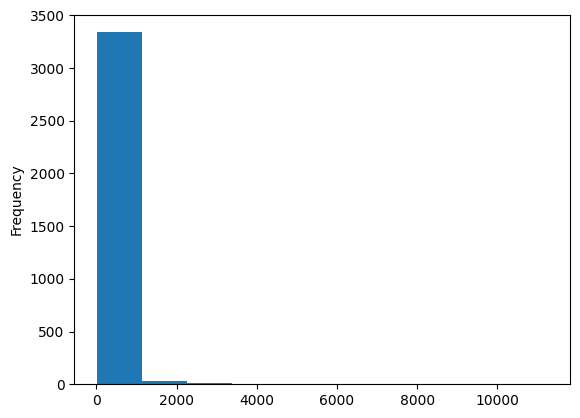

In [27]:
#look at the spread of the lengths of the key sequences to determine the max_sequence_length for padding
filt_df['key_sequence'].apply(lambda x: len(x)).plot.hist()

# Copied from above, get max
print("Median: ", filt_df['key_sequence'].apply(lambda x: len(x)).median())

#since most key_sequence lengths are <300, truncate everything to 300 and pad
#use 2000 as new length since median is 463
# Changing max length to 512 as 512 is the maximium for BERT (copied from: https://huggingface.co/learn/nlp-course/)
max_length = 512

In [28]:
# charbert_train_tokenized = charbert_tokenizer(
#     X_train,
#     max_length=max_length,
#     truncation=True,
#     padding='max_length',
#     return_tensors='pt')

# charbert_val_tokenized = charbert_tokenizer(
#     X_val,
#     max_length=max_length,
#     truncation=True,
#     padding='max_length',
#     return_tensors='pt')

# charbert_test_tokenized = charbert_tokenizer(
#     X_test,
#     max_length=max_length,
#     truncation=True,
#     padding='max_length',
#     return_tensors='pt')

In [29]:
# train_dataset = Dataset.from_dict({'labels': y_train, 'input_ids': charbert_train_tokenized['input_ids'], 'attention_mask': charbert_train_tokenized['attention_mask']})
# val_dataset = Dataset.from_dict({'labels': y_val, 'input_ids': charbert_val_tokenized['input_ids'], 'attention_mask': charbert_val_tokenized['attention_mask']})

In [30]:
# train_dataset

# Model Iterations

## CharBERT Model

In [31]:
# Code copied from: https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
# Pull in a classification version of the model
model = AutoModelForSequenceClassification.from_pretrained(charbert_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at imvladikon/charbert-bert-wiki and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Note on warning that ['classifier.bias', 'classifier.weight'] are newly initialized. From Jennifer's OH: The CharBert model we're using likely wasn't built to work with Hugging Face's loader.
 We're probably losing pre-training. Could try to load it in from git directly, but that will be difficult (3 year old repo) and we'd have to match their python version, etc. Can proceed with this as is, just be aware we're likely losing some (or all?) pre-training.
 Also skimmed: https://discuss.huggingface.co/t/is-some-weights-of-the-model-were-not-used-warning-normal-when-pre-trained-bert-only-by-mlm/5672

In [32]:
# Code copied from: https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
# Set up the arguments we'll use for training
# Additional code (paramters to use in the call) copied from HuggingFaceThreeWays_2_Trainer.ipynb walkthrough
# and from https://www.philschmid.de/getting-started-pytorch-2-0-transformers#3-fine-tune--evaluate-bert-model-with-the-hugging-face-trainer

args = TrainingArguments("test-trainer",
    evaluation_strategy = 'epoch',
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    #load_best_model_at_end=True,
    #metric_for_best_model='f1'
    )

In [33]:
# Put data into a pandas dataframe to then load into a hugging face dataset object
# Code and idea copied from https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html
train_df = pd.DataFrame(X_train)
train_df['labels']=y_train
train_df.columns = ['key_seq','labels']
train_df

,key_seq,labels
0,[unused1] g g n [unused2] e n e r a l l y [unu...,1
1,[unused1] l i n c o n [unused2] l n ' s [unuse...,0
2,[unused1] l i n c o n [unused2] l n ' s [unuse...,0
3,"[unused1] h o w e v e r , [unused3] t h e r e ...",0
4,[unused1] o v e [unused2] [unused2] [unused2] ...,1
...,...,...
2367,[unused1] o o k s [unused3] i n c l u d e [unu...,1
2368,[unused1] t h e [unused3] n o v e l [unused3] ...,1
2369,[unused1] t h e [unused3] n o v e l [unused3] ...,1
2370,[unused1] t h e [unused3] n o v e l [unused3] ...,1


In [34]:
# Code copied from above
# Made a df of our validation data
val_df = pd.DataFrame(X_val)
val_df['labels']=y_val
val_df.columns = ['key_seq','labels']
val_df

,key_seq,labels
0,[unused1] t h e [unused3] f o u g h t [unused3...,0
1,[unused1] o v e r [unused3] t h r e e [unused3...,0
2,[unused1] h e [unused3] i s [unused3] b u r i ...,1
3,[unused1] a l t h o u g h [unused3] e a r l y ...,1
4,[unused1] t h e y [unused3] g o u h t [unused3...,1
...,...,...
503,[unused1] t h e [unused3] [unused1] f r a n k ...,0
504,[unused1] b o o k s [unused3] i n c l u d e [u...,1
505,[unused1] t h r [unused3] [unused1] f r a n k ...,0
506,[unused1] a s [unused3] o f [unused3] 2 0 0 4 ...,0


In [35]:
# Code copied from above
# Made a df of our test data
test_df = pd.DataFrame(X_test)
test_df['labels']=y_test
test_df.columns = ['key_seq','labels']
test_df

,key_seq,labels
0,[unused1] a s [unused3] o f [unused3] 2 0 0 4 ...,0
1,[unused1] t h e [unused3] [unused1] f r a n k ...,1
2,[unused1] o v e r [unused3] t h r e e [unused3...,0
3,[unused1] b o o k s [unused3] i n c l u d e [u...,0
4,[unused1] a l t h o u g h [unused3] e a r l y ...,0
...,...,...
504,[unused1] a s [unused3] o f [unused3] 2 0 0 4 ...,0
505,[unused1] g e n e r a l l y [unused3] c o n s ...,1
506,[unused1] t h e [unused3] n o v e l [unused3] ...,0
507,[unused1] t h e [unused3] n o v e l [unused3] ...,0


In [36]:
# Code copied from https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html
# Make a hugging face dataset object from the pandas df we just made
train_dataset = Dataset.from_pandas(train_df)
train_dataset

Dataset({
    features: ['key_seq', 'labels'],
    num_rows: 2372
})

In [37]:
# Code copied from above
# Make a validation Dataset
val_dataset = Dataset.from_pandas(val_df)
val_dataset

Dataset({
    features: ['key_seq', 'labels'],
    num_rows: 508
})

In [38]:
# Code copied from above
# Make a test Dataset
test_dataset = Dataset.from_pandas(test_df)
test_dataset

Dataset({
    features: ['key_seq', 'labels'],
    num_rows: 509
})

In [39]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt and prior code above (likely from BERT lesson notebooks/assignment)
# Code also copied from https://huggingface.co/learn/nlp-course/chapter2/2?fw=pt
# Create a tokenize function we'll use to tokenize the key sequences in the dataset
def tokenize_func(a):
  return charbert_tokenizer(
    a['key_seq'],
    # Changing padding to max_length, copied from https://huggingface.co/learn/nlp-course/chapter2/6?fw=pt
    # Getting rid of padding here (copying from https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt).
    # It's more efficient to do padding at the batch level later on (use "dynamic padding") according to the above source
    # padding='max_length',
    # Trunction true should truncate to max length: Copied from https://huggingface.co/docs/transformers/main_classes/tokenizer
    truncation=True,
    # Testing a shorter max length based on https://huggingface.co/learn/nlp-course/chapter2/5?fw=pt
    # Getting rid of max length from here to, copying from: https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
    # Reinstating max length since got an error
    max_length=max_length,
    # Getting rid of return tensors so that this code runs! Gave an erron when it was here
    # return_tensors='pt'
    )

In [40]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
# Tokenize the key sequences which will add the results to the dataset
tokenized_train_dataset = train_dataset.map(tokenize_func, batched=True)
tokenized_train_dataset

Map:   0%|          | 0/2372 [00:00<?, ? examples/s]

Dataset({
    features: ['key_seq', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2372
})

In [41]:
# Code copied from above
# Tokenize validation dataset
tokenized_val_dataset = val_dataset.map(tokenize_func, batched=True)
tokenized_val_dataset

Map:   0%|          | 0/508 [00:00<?, ? examples/s]

Dataset({
    features: ['key_seq', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 508
})

In [42]:
# Code copied from above
# Tokenize test dataset
tokenized_test_dataset = test_dataset.map(tokenize_func, batched=True)
tokenized_test_dataset

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Dataset({
    features: ['key_seq', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 509
})

In [43]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
  # Copied from https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt:
  # "... apply the correct amount of padding to the items of the dataset we want to batch together.
  # ... such a function via DataCollatorWithPadding. It takes a tokenizer when you instantiate it
   #(to know which padding token to use, and whether the model expects padding to be on the left or on the right of the inputs)
# Setting max length, and padding - copied from https://huggingface.co/docs/transformers/main_classes/data_collator
# Errored out, so got rid of these
data_collator = DataCollatorWithPadding(tokenizer=charbert_tokenizer)

In [44]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
# Make sure data collator is working correctly

# trial = tokenized_train_dataset[:]
# trial = {k: v for k, v in trial.items() if k not in ["key_seq"]}
# lens_pre = np.array([len(x) for x in trial['input_ids']])
# print(lens_pre)
# print("max length before the data collator:", lens_pre.max())

# colled = data_collator(trial)
# lens_post = np.array([len(x) for x in colled['input_ids']])
# print(lens_post)
# print("max length post data collator:",lens_post.max())

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[144 128 130 ... 121 129 152]
max length before the data collator: 512
[512 512 512 ... 512 512 512]
max length post data collator: 512


In [45]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=data_collator,
    tokenizer=charbert_tokenizer
)

In [46]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.698190
2,No log,0.692687
3,No log,0.688629
4,0.683400,0.684578
5,0.683400,0.696131
6,0.683400,0.689774
7,0.671900,0.682984
8,0.671900,0.681863
9,0.671900,0.696264
10,0.671900,0.698237


TrainOutput(global_step=1490, training_loss=0.6728130366178167, metrics={'train_runtime': 1010.5117, 'train_samples_per_second': 23.473, 'train_steps_per_second': 1.475, 'total_flos': 2474168920188000.0, 'train_loss': 0.6728130366178167, 'epoch': 10.0})

In [47]:
# Get predictions from the model for the validation dataset
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
predictions = trainer.predict(tokenized_val_dataset)
print(predictions.predictions.shape,predictions.label_ids.shape)

(508, 2) (508,)


In [48]:
# Eyeball the predictions
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
predictions.predictions

array([[ 0.02350063,  0.14271566],
       [ 0.25347117, -0.04507782],
       [ 0.55704045, -0.32161784],
       ...,
       [ 1.1405506 , -0.6295533 ],
       [ 0.59741974, -0.38886833],
       [ 0.37571916, -0.16020583]], dtype=float32)

In [49]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
# "As you can see, predictions is a two-dimensional array with shape 408 x 2 (408 being the number of elements in the dataset we used).
# Those are the logits for each element of the dataset we passed to predict() (as you saw in the previous chapter, all Transformer models return logits).
# To transform them into predictions that we can compare to our labels, we need to take the index with the maximum value on the second axis"
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
charBert_pred_labels = np.argmax(predictions.predictions, axis=-1)
charBert_pred_labels

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [50]:
# Now let's evaluate the model (code copied from above)

accuracy_charBERT = accuracy_score(np.array(y_val), charBert_pred_labels)
precision_charBERT = precision_score(np.array(y_val), charBert_pred_labels)
recall_charBERT = recall_score(np.array(y_val), charBert_pred_labels)
f1_charBERT = f1_score(np.array(y_val), charBert_pred_labels)

print("Accuracy: ", accuracy_charBERT)
print("Precision: ", precision_charBERT)
print("Recall: ", recall_charBERT)
print("F1-Score: ", f1_charBERT)

Accuracy:  0.5767716535433071
Precision:  0.6025641025641025
Recall:  0.20346320346320346
F1-Score:  0.3042071197411003


In [51]:
print("Share of 0s in train:",1-(np.array(y_train).sum()/len(y_train)))
print("Share of 0s in val:",1-(np.array(y_val).sum()/len(y_val)))

Share of 0s in train: 0.5796795952782462
Share of 0s in val: 0.545275590551181


## BERT Model

In [52]:
# Code copied from above
bert_checkpoint = 'bert-base-uncased'
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# Code copied from above
bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint)

In [54]:
# Code copied from above, add the special tokens
bert_tokenizer.add_tokens(added_tokens)

26

In [55]:
# Code copied from above
bert_args = TrainingArguments("bert",
    evaluation_strategy = 'epoch',
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    #load_best_model_at_end=True,
    #metric_for_best_model='f1'
    )

In [56]:
# Code copied from above
def tokenize_func_bert(a):
  return bert_tokenizer(
    a['key_seq'],
    truncation=True,
    max_length=max_length,
    )

In [57]:
# Code copied from above
tokenized_train_dataset_bert = train_dataset.map(tokenize_func_bert, batched=True)
tokenized_train_dataset_bert

Map:   0%|          | 0/2372 [00:00<?, ? examples/s]

Dataset({
    features: ['key_seq', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2372
})

In [58]:
# Code copied from above
tokenized_val_dataset_bert = val_dataset.map(tokenize_func_bert, batched=True)
tokenized_val_dataset_bert

Map:   0%|          | 0/508 [00:00<?, ? examples/s]

Dataset({
    features: ['key_seq', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 508
})

In [59]:
# Code copied from above
tokenized_test_dataset_bert = test_dataset.map(tokenize_func_bert, batched=True)
tokenized_test_dataset_bert

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Dataset({
    features: ['key_seq', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 509
})

In [60]:
# Code copied from above
data_collator_bert = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [61]:
# Code copied from above
trainer_bert = Trainer(
    bert_model,
    bert_args,
    train_dataset=tokenized_train_dataset_bert,
    eval_dataset=tokenized_val_dataset_bert,
    data_collator=data_collator_bert,
    tokenizer=bert_tokenizer
)

In [62]:
trainer_bert.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,0.697237
2,No log,0.692634
3,No log,0.715687
4,0.681100,0.682271
5,0.681100,0.713042
6,0.681100,0.688048
7,0.671800,0.689562
8,0.671800,0.695342
9,0.671800,0.700572
10,0.671800,0.696455


TrainOutput(global_step=1490, training_loss=0.668835428737154, metrics={'train_runtime': 1048.5752, 'train_samples_per_second': 22.621, 'train_steps_per_second': 1.421, 'total_flos': 2474168920188000.0, 'train_loss': 0.668835428737154, 'epoch': 10.0})

In [63]:
# Code copied from above
bert_predictions = trainer_bert.predict(tokenized_val_dataset_bert)

In [64]:
# Code copied from above
bert_pred_labels = np.argmax(bert_predictions.predictions, axis=-1)
bert_pred_labels

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,

In [65]:
# Code copied from above
accuracy_bert = accuracy_score(np.array(y_val), bert_pred_labels)
precision_bert = precision_score(np.array(y_val), bert_pred_labels)
recall_bert = recall_score(np.array(y_val), bert_pred_labels)
f1_bert = f1_score(np.array(y_val), bert_pred_labels)

print("Accuracy: ", accuracy_bert)
print("Precision: ", precision_bert)
print("Recall: ", recall_bert)
print("F1-Score: ", f1_bert)

Accuracy:  0.5669291338582677
Precision:  0.5337423312883436
Recall:  0.37662337662337664
F1-Score:  0.4416243654822335


# Graveyard

In [ ]:
# Idea copied from https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
# Let's add the labels to the tokens
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
charbert_train_tokenized['labels'] = torch.tensor(y_train)
charbert_train_tokenized

In [ ]:
# RUNS OUT OF RAM
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt

# import torch
# from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

# optimizer = AdamW(model.parameters())
# loss = model(**charbert_train_tokenized).loss
# loss.backward()
# optimizer.step()

In [ ]:
#do MORE data manipulation to put everything in the right format for PYTORCH
from torch.utils.data import DataLoader, TensorDataset

#####train data
train_input_ids = charbert_train_tokenized['input_ids']

train_attention_mask = charbert_train_tokenized['attention_mask']

train_labels = torch.tensor(y_train)

#create a TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)

#create a DataLoader
batch_size = 32 #hyperparameter??
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)


#####val data
val_input_ids = charbert_val_tokenized['input_ids']

val_attention_mask = charbert_val_tokenized['attention_mask']

val_labels = torch.tensor(y_val)

#create a TensorDataset
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)

#create a DataLoader
# batch_size = 32 #hyperparameter??
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


######test data
test_input_ids = charbert_test_tokenized['input_ids']

test_attention_mask = charbert_test_tokenized['attention_mask']

test_labels = torch.tensor(y_test)

#create a TensorDataset
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)

#create a DataLoader
# batch_size = 32 #hyperparameter??
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
train_dataset[0]

(tensor([101,   1, 176,  ...,   0,   0,   0]),
 tensor([1, 1, 1,  ..., 0, 0, 0]),
 tensor(1))

In [ ]:
from transformers.modeling_tf_utils import DataCollatorWithPadding
# from transformers import DataCollator

# class CustomDataCollator(DataCollator):
#     def __init__(self, tokenizer):
#         self.tokenizer = tokenizer

#     def collate_batch(self, batch):
#         input_ids = torch.stack([item['input_ids'] for item in batch])
#         attention_mask = torch.stack([item['attention_mask'] for item in batch])
#         labels = torch.tensor([item['labels'] for item in batch])

#         return {
#             'input_ids': input_ids,
#             'attention_mask': attention_mask,
#             'labels': labels
#         }

# Create a custom data collator
# custom_data_collator = CustomDataCollator(charbert_tokenizer)

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=charbert_tokenizer
)
trainer.train()

RuntimeError: ignored

In [ ]:
#make data_collator for charbert; it's a dictionary of token ids to vocab
# data_collator = DataCollatorWithPadding(tokenizer=charbert_tokenizer)

# Define your custom data collator
class CustomDataCollator:
    def __init__(self):
        pass

    def __call__(self, features):
        # Extract tensors from the tokenizers.Encoding objects
        input_ids = torch.stack([feature.input_ids for feature in features])
        attention_mask = torch.stack([feature.attention_mask for feature in features])
        # Add other necessary tensors if applicable

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            # Add other tensors here
        }

# Create your custom data collator
custom_data_collator = CustomDataCollator()

trainer = Trainer(
    model,
    args,
    train_dataset=charbert_train_tokenized,
    eval_dataset=charbert_val_tokenized,
    data_collator=custom_data_collator,
    tokenizer=charbert_tokenizer,
)


#fine tune
trainer.train()

AttributeError: ignored

In [ ]:
model_checkpoint = charbert_name

def create_charbert_model(checkpoint = model_checkpoint,
                          num_train_layers = 0,
                          hidden_size = [3, 5, 2],
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = AutoModel.from_pretrained(checkpoint)

    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    # pooler
    # token = bert_out[1]

    # cls
    # token = bert_out[0][:, 0, :]

    # avg
    token = tf.math.reduce_mean(bert_out[0], 1)

    hidden = tf.keras.layers.Dense(hidden_size[0], activation='relu')(token)
    for i in hidden_size[1:]:
      hidden = tf.keras.layers.Dense(i, activation='relu')(hidden)
      hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model


In [ ]:
charbert_avg_model = create_charbert_model()

charbert_avg_model_history = charbert_avg_model.fit(
    charbert_train_tokenized,
    y_train,
    validation_data=(charbert_val_tokenized, y_val),
    batch_size=8,
    epochs=2
)


TypeError: ignored